In [1]:
import glob, os, sys
import pathlib
import timeit
import itertools
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import display


#data_directory = '/media/matthias/Big-disk/text/pubmed_200k_and_20k_rct_dataset/'
data_directory = "."


def get_sentence_from_line(line, token_prefix = ''):
    sentence = line.split('\t')[1].lower()
    if token_prefix != '':
        tokens = sentence.split(' ')
        sentence = ' '.join([token_prefix + token for token in tokens])
    return sentence


def get_label_from_line(line):
    return line.split('\t')[0]


def preprocess_corpora(input_filenames, add_position_information = False, included_context_sentence_offset = [], \
                       excluded_chunk_ids = [], omit_labels = False, output_file_postfix = '.preprocessed'):
    for input_filename in input_filenames:

        fin = open(input_filename,'r')

        output_filename = input_filename + output_file_postfix
        fout = open(output_filename, 'w')

        text_chunk_in = ""

        # iterate through lines in input file
        for line in fin:
                
                # lines starting with ### mark beginning of new abstract ('chunk')
                if line.startswith('###'):
                    chunk_id = line
                    text_chunk_in = ''
                
                # blank lines mark end of chunk. process chunk and write to file.
                elif line.isspace() and (chunk_id not in excluded_chunk_ids):
                        chunk_lines = text_chunk_in.splitlines()

                        last_line_index = len(chunk_lines) - 1
                        
                        # iterate through lines in text chunk
                        for chunk_line_number, chunk_line in enumerate(chunk_lines, start=0):

                                sentence = get_sentence_from_line(chunk_line)

                                context_sentences = []
                                
                                # generate context sentences, prepend tokens with 
                                # specific strings based on context sentence offset
                                for sentence_offset in included_context_sentence_offset:
                                    if not (0 <= chunk_line_number + sentence_offset <= last_line_index):
                                        context_sentences.append('no__' + str(sentence_offset))
                                    else: 
                                        context_sentences.append(get_sentence_from_line( \
                                                                    chunk_lines[chunk_line_number+sentence_offset], \
                                                                    token_prefix = str(sentence_offset) + '__'))

                                
                                
                                if add_position_information:
                                    sentence = "sentence__{} of__{} {} {}\n".format( \
                                        str(chunk_line_number), str(last_line_index), sentence, ' '.join(context_sentences))
                                else:
                                    sentence = "{} {}\n".format( \
                                        sentence, ' '.join(context_sentences))
                                
                                if omit_labels:
                                    fout.write(sentence)
                                else:
                                    label = get_label_from_line(chunk_line).lower()

                                    if 'background' in label:
                                            fout.write('__label__background\t'+sentence)
                                    elif 'methods' in label:
                                            fout.write('__label__methods\t'+sentence)
                                    elif 'results' in label:
                                            fout.write('__label__results\t'+sentence)
                                    elif 'conclusions' in label:
                                            fout.write('__label__conclusions\t'+sentence)
                                    elif 'objective' in label:
                                            fout.write('__label__objective\t'+sentence)
                
                # otherwise, this is a line containing a labelled sentence
                else:
                        text_chunk_in += line

        fin.close()
        fout.close()


def fasttext_train(train_filename, model_filename, params, pretrained_vector_file):
    if pretrained_vector_file:
        ! fasttext supervised -input $train_filename -output $model_filename -pretrainedVectors $pretrained_vector_file -dim {params['dim']} -wordNgrams {params['wordNgrams']} -epoch {params['epoch']} -verbose 0
    else:
        ! fasttext supervised -input $train_filename -output $model_filename -dim {params['dim']} -wordNgrams {params['wordNgrams']} -epoch {params['epoch']} -verbose 0


def plot_confusion_matrix(cm, labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
        
def fasttext_test(model_filename, test_filename, plot_matrix = False):
    y_true = []
    with open(test_filename, 'r') as fin:
        for line in fin:
            y_true.append(line.split('\t')[0])
    
    output = ! fasttext predict $model_filename $test_filename
    y_pred = []
    for line in output:
        y_pred.append(line)
    
    precision = metrics.precision_score(y_true, y_pred, average='weighted')
    recall = metrics.recall_score(y_true, y_pred, average='weighted')
    f1 = metrics.f1_score(y_true, y_pred, average='weighted')
    
    if plot_matrix:
        labels = ["__label__objective",
                  "__label__background",
                  "__label__methods",
                  "__label__results",
                  "__label__conclusions"]         
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred, labels)
        np.set_printoptions(precision=2)
        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, labels=labels, title='Confusion matrix, without normalization')
        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, labels=labels, normalize=True, title='Normalized confusion matrix')
        plt.show()
        
    return precision, recall, f1


def train_and_test(train_filename, model_filename, test_filename, params, pretrained_vector_file=None, \
                   plot_matrix=False, verbose=False):
    if verbose:
        print("\n" + str(params))
    
    start_time = timeit.default_timer()
    fasttext_train(train_filename, model_filename, params, pretrained_vector_file)
    training_time = timeit.default_timer() - start_time
    
    precision, recall, f1 = fasttext_test(model_filename + '.bin', test_filename, plot_matrix)
    results = {'precision': precision, 'recall': recall, 'f1': f1, 'training_time': training_time}
    if verbose:
        print(str(results))
    
    return dict(results, **params)

# Train and evaluate on PubMed RCT corpora

In [12]:
input_filenames = [data_directory + '/PubMed_200k_RCT/train.txt',
                   data_directory + '/PubMed_200k_RCT/dev.txt',
                   data_directory + '/PubMed_200k_RCT/test.txt',
                   data_directory + '/PubMed_20k_RCT/train.txt',
                   data_directory + '/PubMed_20k_RCT/dev.txt',
                   data_directory + '/PubMed_20k_RCT/test.txt']

preprocess_corpora(input_filenames, add_position_information = True, included_context_sentence_offset = [-2, -1, +1, +2])

## Train and evaluate on 200k: with sentence context and numeric text position

In [2]:
param_grid = {'dim': [10, 20, 50], 'wordNgrams': [1, 2, 3, 4], 'epoch': [1, 2, 3, 4, 5]}
test_results_df = pd.DataFrame(columns = ['precision', 'recall', 'training_time'] + (list(param_grid.keys())))

for params in ParameterGrid(param_grid):
    test_results_df = test_results_df.append(train_and_test(data_directory + "/PubMed_200k_RCT/train.txt.preprocessed",\
                                "fasttext-model", \
                                data_directory + "/PubMed_200k_RCT/dev.txt.preprocessed", params), ignore_index=True)
    

display(test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]))

,precision,recall,training_time,dim,wordNgrams,epoch,f1
30,0.917101,0.917427,72.889973,20.0,3.0,3.0,0.916986
9,0.917010,0.917358,52.648995,10.0,2.0,3.0,0.916943
10,0.916700,0.917012,63.986333,10.0,3.0,3.0,0.916576
50,0.916566,0.916943,119.676297,50.0,3.0,3.0,0.916531
29,0.916276,0.916805,59.837500,20.0,2.0,3.0,0.916404
14,0.916422,0.916770,76.157604,10.0,3.0,4.0,0.916377
35,0.916338,0.916701,106.653597,20.0,4.0,4.0,0.916285
15,0.916134,0.916598,92.758531,10.0,4.0,4.0,0.916200
55,0.916096,0.916563,184.115231,50.0,4.0,4.0,0.916186
51,0.916176,0.916632,151.985700,50.0,4.0,3.0,0.916181


Confusion matrix, without normalization
[[1704  573   98    0    2]
 [ 471 2051   91    8   42]
 [  25   36 9375  296   19]
 [   3    3  395 9744  131]
 [   1   23   13  203 4186]]
Normalized confusion matrix
[[7.17e-01 2.41e-01 4.12e-02 0.00e+00 8.41e-04]
 [1.77e-01 7.70e-01 3.42e-02 3.00e-03 1.58e-02]
 [2.56e-03 3.69e-03 9.61e-01 3.04e-02 1.95e-03]
 [2.92e-04 2.92e-04 3.84e-02 9.48e-01 1.27e-02]
 [2.26e-04 5.20e-03 2.94e-03 4.59e-02 9.46e-01]]


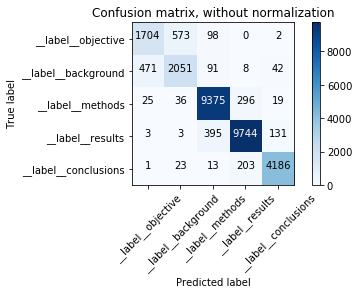

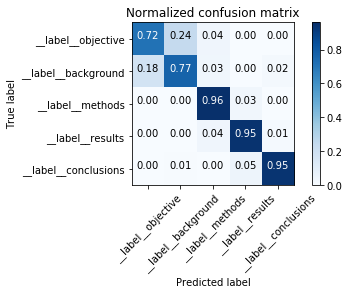

{'precision': 0.9166970965292606,
 'recall': 0.9175058488454888,
 'f1': 0.9169707069729037,
 'training_time': 72.87703686498571,
 'dim': 20,
 'wordNgrams': 3,
 'epoch': 3}

In [3]:
# test on test set with  hyperparameter settings that achieved best results 
# (this will also be done for all following evaluations)
train_and_test(data_directory + "/PubMed_200k_RCT/train.txt.preprocessed", \
               "fasttext-model-best-200k-with-context", data_directory + "/PubMed_200k_RCT/test.txt.preprocessed", \
               {'dim': 20, 'wordNgrams': 3, 'epoch': 3}, plot_matrix=True)

## Train and evaluate on 20k: with sentence context and numeric text position

In [6]:
param_grid = {'dim': [10, 20, 50], 'wordNgrams': [1, 2, 3, 4], 'epoch': [1, 2, 3, 4, 5, 6, 7, 8]}
test_results_df = pd.DataFrame(columns = ['precision', 'recall', 'training_time'] + (list(param_grid.keys())))

for params in ParameterGrid(param_grid):
    test_results_df = test_results_df.append(train_and_test(data_directory + "/PubMed_20k_RCT/train.txt.preprocessed", \
                                "fasttext-model", \
                                data_directory + "/PubMed_20k_RCT/dev.txt.preprocessed", params), ignore_index=True)
    

display(test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]))

,precision,recall,training_time,dim,wordNgrams,epoch,f1
57,0.898040,0.898815,10.779183,20.0,2.0,7.0,0.897811
61,0.897671,0.898451,11.480299,20.0,2.0,8.0,0.897460
25,0.897549,0.898385,8.843147,10.0,2.0,7.0,0.897323
89,0.897472,0.898319,18.699714,50.0,2.0,7.0,0.897254
93,0.897224,0.898186,19.698277,50.0,2.0,8.0,0.897219
29,0.896861,0.897921,9.576894,10.0,2.0,8.0,0.896995
85,0.897200,0.898087,17.699787,50.0,2.0,6.0,0.896949
30,0.897129,0.897988,12.050101,10.0,3.0,8.0,0.896797
53,0.896607,0.897690,10.012631,20.0,2.0,6.0,0.896702
94,0.896515,0.897623,25.696181,50.0,3.0,8.0,0.896568


Test on test set with  hyperparameter settings that achieved best result on validation set

In [21]:
best_hyperparameters = test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]).values[0]
best_dim = best_hyperparameters[3]
best_wordNgrams = best_hyperparameters[4]
best_epoch = best_hyperparameters[5]

train_and_test(data_directory + "/PubMed_20k_RCT/train.txt.preprocessed", \
               "fasttext-model-best-20k-with-context", data_directory + "/PubMed_20k_RCT/test.txt.preprocessed", \
               {'dim': best_dim, 'wordNgrams': best_wordNgrams, 'epoch': best_epoch})

{'precision': 0.8955564879387669,
 'recall': 0.896797743487639,
 'f1': 0.8958456835363864,
 'training_time': 10.895047472033184,
 'dim': 20.0,
 'wordNgrams': 2.0,
 'epoch': 7.0}

## Ablation experiment on 200k: no sentence context

In [22]:
preprocess_corpora(input_filenames, add_position_information = True)

In [10]:
param_grid = {'dim': [10, 20, 50], 'wordNgrams': [1, 2, 3, 4], 'epoch': [1, 2, 3, 4, 5]}
test_results_df = pd.DataFrame(columns = ['precision', 'recall', 'training_time'] + (list(param_grid.keys())))

for params in ParameterGrid(param_grid):
    test_results_df = test_results_df.append(train_and_test(data_directory + "/PubMed_200k_RCT/train.txt.preprocessed",\
                                "fasttext-model", \
                                data_directory + "/PubMed_200k_RCT/dev.txt.preprocessed", params), ignore_index=True)
    

display(test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]))

,precision,recall,training_time,dim,wordNgrams,epoch,f1
46,0.905616,0.906125,19.669332,50.0,3.0,2.0,0.905535
50,0.904635,0.905226,23.678574,50.0,3.0,3.0,0.904760
31,0.904190,0.904638,17.520408,20.0,4.0,3.0,0.904139
26,0.904077,0.904708,12.191093,20.0,3.0,2.0,0.904063
47,0.904574,0.904638,22.762766,50.0,4.0,2.0,0.904025
30,0.904017,0.904466,14.992033,20.0,3.0,3.0,0.903983
45,0.903557,0.904327,16.802190,50.0,2.0,2.0,0.903788
51,0.903718,0.904258,28.200353,50.0,4.0,3.0,0.903756
29,0.903785,0.904189,12.568551,20.0,2.0,3.0,0.903652
27,0.903836,0.904224,13.820534,20.0,4.0,2.0,0.903624


In [23]:
best_hyperparameters = test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]).values[0]
best_dim = best_hyperparameters[3]
best_wordNgrams = best_hyperparameters[4]
best_epoch = best_hyperparameters[5]

train_and_test(data_directory + "/PubMed_200k_RCT/train.txt.preprocessed", \
               "fasttext-model", data_directory + "/PubMed_200k_RCT/test.txt.preprocessed", \
               {'dim': best_dim, 'wordNgrams': best_wordNgrams, 'epoch': best_epoch})

{'precision': 0.9036689369905331,
 'recall': 0.9044519038415896,
 'f1': 0.9037921156450701,
 'training_time': 19.69586681801593,
 'dim': 50,
 'wordNgrams': 3,
 'epoch': 2}

## Ablation experiment on 200k: no numeric text position

In [25]:
preprocess_corpora(input_filenames, add_position_information = False, included_context_sentence_offset = [-2, -1, +1, +2])

In [26]:
param_grid = {'dim': [10, 20, 50], 'wordNgrams': [1, 2, 3, 4], 'epoch': [1, 2, 3, 4, 5]}
test_results_df = pd.DataFrame(columns = ['precision', 'recall', 'training_time'] + (list(param_grid.keys())))

for params in ParameterGrid(param_grid):
    test_results_df = test_results_df.append(train_and_test(data_directory + "/PubMed_200k_RCT/train.txt.preprocessed",\
                                "fasttext-model", \
                                data_directory + "/PubMed_200k_RCT/dev.txt.preprocessed", params), ignore_index=True)
    

display(test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]))

,precision,recall,training_time,dim,wordNgrams,epoch,f1
49,0.912586,0.913072,90.355506,50.0,2.0,3.0,0.912676
29,0.912415,0.913003,58.767690,20.0,2.0,3.0,0.912618
30,0.912342,0.912968,70.967897,20.0,3.0,3.0,0.912536
9,0.912310,0.912865,53.259038,10.0,2.0,3.0,0.912476
53,0.912296,0.912796,103.080753,50.0,2.0,4.0,0.912414
55,0.912167,0.912692,181.517021,50.0,4.0,4.0,0.912298
31,0.912226,0.912726,86.319335,20.0,4.0,3.0,0.912230
10,0.912033,0.912554,64.662209,10.0,3.0,3.0,0.912111
51,0.911986,0.912519,151.195873,50.0,4.0,3.0,0.912066
33,0.911834,0.912415,67.215241,20.0,2.0,4.0,0.912046


In [27]:
best_hyperparameters = test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]).values[0]
best_dim = best_hyperparameters[3]
best_wordNgrams = best_hyperparameters[4]
best_epoch = best_hyperparameters[5]

train_and_test(data_directory + "/PubMed_200k_RCT/train.txt.preprocessed", \
               "fasttext-model", data_directory + "/PubMed_200k_RCT/test.txt.preprocessed", \
               {'dim': best_dim, 'wordNgrams': best_wordNgrams, 'epoch': best_epoch})

{'precision': 0.9117295025315909,
 'recall': 0.9126911470518428,
 'f1': 0.9121130948512021,
 'training_time': 90.68823781202082,
 'dim': 50.0,
 'wordNgrams': 2.0,
 'epoch': 3.0}

## Train and evaluate on 200k: single sentences

In [28]:
input_filenames = [data_directory + '/PubMed_200k_RCT/train.txt',
                   data_directory + '/PubMed_200k_RCT/dev.txt',
                   data_directory + '/PubMed_200k_RCT/test.txt',
                   data_directory + '/PubMed_20k_RCT/train.txt',
                   data_directory + '/PubMed_20k_RCT/dev.txt',
                   data_directory + '/PubMed_20k_RCT/test.txt']

preprocess_corpora(input_filenames, add_position_information = False, included_context_sentence_offset = [])

In [29]:
param_grid = {'dim': [10, 20, 50], 'wordNgrams': [1, 2, 3, 4], 'epoch': [1, 2, 3, 4, 5]}
test_results_df = pd.DataFrame(columns = ['precision', 'recall', 'training_time'] + (list(param_grid.keys())))

for params in ParameterGrid(param_grid):
    test_results_df = test_results_df.append(train_and_test(data_directory + "/PubMed_200k_RCT/train.txt.preprocessed", \
                                "fasttext-model", \
                                data_directory + "/PubMed_200k_RCT/dev.txt.preprocessed", params), ignore_index=True)
    

display(test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]))

,precision,recall,training_time,dim,wordNgrams,epoch,f1
10,0.856218,0.857701,12.604724,10.0,3.0,3.0,0.856723
6,0.855872,0.857874,10.012537,10.0,3.0,2.0,0.856685
46,0.855983,0.857632,20.233011,50.0,3.0,2.0,0.856476
47,0.855697,0.857666,23.582715,50.0,4.0,2.0,0.856370
26,0.855516,0.857424,12.095511,20.0,3.0,2.0,0.856185
7,0.855255,0.857251,11.300829,10.0,4.0,2.0,0.855942
49,0.855173,0.856871,19.602251,50.0,2.0,3.0,0.855795
50,0.855000,0.856733,23.713091,50.0,3.0,3.0,0.855733
29,0.855039,0.856733,12.471415,20.0,2.0,3.0,0.855611
27,0.854758,0.856698,13.702235,20.0,4.0,2.0,0.855408


In [30]:
best_hyperparameters = test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]).values[0]
best_dim = best_hyperparameters[3]
best_wordNgrams = best_hyperparameters[4]
best_epoch = best_hyperparameters[5]

train_and_test(data_directory + "/PubMed_200k_RCT/train.txt.preprocessed", \
               "fasttext-model-best-200k-without-context", data_directory + "/PubMed_200k_RCT/test.txt.preprocessed", \
               {'dim': best_dim, 'wordNgrams': best_wordNgrams, 'epoch': best_epoch})

{'precision': 0.8516751086335898,
 'recall': 0.8536940969043502,
 'f1': 0.8524537656652637,
 'training_time': 13.192951773991808,
 'dim': 10.0,
 'wordNgrams': 3.0,
 'epoch': 3.0}

## Train and evaluate on 20k: single sentences

In [31]:
# run hyperparameter grid search, test on validation set
param_grid = {'dim': [10, 20, 50], 'wordNgrams': [1, 2, 3, 4], 'epoch': [1, 2, 3, 4, 5, 6, 7, 8]}
test_results_df = pd.DataFrame(columns = ['precision', 'recall', 'training_time'] + (list(param_grid.keys())))

for params in ParameterGrid(param_grid):
    test_results_df = test_results_df.append(train_and_test(data_directory + "/PubMed_20k_RCT/train.txt.preprocessed", \
                                "fasttext-model", \
                                data_directory + "/PubMed_20k_RCT/dev.txt.preprocessed", params), ignore_index=True)
    

display(test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]))

,precision,recall,training_time,dim,wordNgrams,epoch,f1
82,0.836118,0.838044,5.178981,50.0,3.0,5.0,0.836443
78,0.837475,0.838210,4.816645,50.0,3.0,4.0,0.836391
86,0.836501,0.837813,5.460495,50.0,3.0,6.0,0.836387
95,0.836463,0.837813,7.027800,50.0,4.0,8.0,0.836322
45,0.836303,0.837713,2.294314,20.0,2.0,4.0,0.836216
58,0.835953,0.837482,3.181795,20.0,3.0,7.0,0.836047
83,0.836827,0.837614,5.740808,50.0,4.0,5.0,0.835924
50,0.836363,0.837316,2.770476,20.0,3.0,5.0,0.835920
87,0.835970,0.837217,6.140774,50.0,4.0,6.0,0.835809
55,0.836133,0.837184,3.358261,20.0,4.0,6.0,0.835786


In [32]:
best_hyperparameters = test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]).values[0]
best_dim = best_hyperparameters[3]
best_wordNgrams = best_hyperparameters[4]
best_epoch = best_hyperparameters[5]

train_and_test(data_directory + "/PubMed_20k_RCT/train.txt.preprocessed", \
               "fasttext-model-best-20k-without-context", data_directory + "/PubMed_20k_RCT/test.txt.preprocessed", \
               {'dim': best_dim, 'wordNgrams': best_wordNgrams, 'epoch': best_epoch})

{'precision': 0.825348709916406,
 'recall': 0.8270781483325037,
 'f1': 0.8254880799749762,
 'training_time': 5.170542317908257,
 'dim': 50.0,
 'wordNgrams': 3.0,
 'epoch': 5.0}

# Train and evaluate on enhanced corpus

## Train and evaluate on enhanced corpus: with sentence context and numeric text position

Get set of PubMed articles that are both in the 200k and in our extension dataset. We don't want duplicate entries, or have a dev/test article in our training set.

In [5]:
def get_pmids_from_file(input_filename):
    ids = set()
    fin = open(input_filename,'r')
    for line in fin:
        if line.startswith('###'):
            ids.add(line)
    fin.close()
    return(ids)


pmids_in_200k = get_pmids_from_file(data_directory + "/PubMed_200k_RCT/train.txt") | \
                get_pmids_from_file(data_directory + "/PubMed_200k_RCT/dev.txt") | \
                get_pmids_from_file(data_directory + "/PubMed_200k_RCT/test.txt")

pmids_in_extension_corpus =  get_pmids_from_file(data_directory + "/article_segments_with_stanford_parser_for_SDL2.txt")

overlapping_ids_in_200k_and_extension_corpus = pmids_in_200k.intersection(pmids_in_extension_corpus)

print("Number of overlapping articles that will be removed before merging corpora: " + \
      str(len(overlapping_ids_in_200k_and_extension_corpus)))

Number of overlapping articles that will be removed before merging corpora: 60608


In [9]:
# Number of articles in extended trainig corpus after removing overlaps with 200k dataset
len(get_pmids_from_file(data_directory + "/PubMed_200k_RCT/train.txt")) + len(pmids_in_extension_corpus) - len(overlapping_ids_in_200k_and_extension_corpus)

872247

In [3]:
preprocess_corpora([data_directory + "/article_segments_with_stanford_parser_for_SDL2.txt"], \
                   add_position_information = True, included_context_sentence_offset = [-2, -1, +1, +2], \
                   excluded_chunk_ids = overlapping_ids_in_200k_and_extension_corpus)

preprocess_corpora([data_directory + "/PubMed_200k_RCT/train.txt", \
                    data_directory + "/PubMed_200k_RCT/dev.txt", \
                    data_directory + "/PubMed_200k_RCT/test.txt"], \
                    add_position_information = True, included_context_sentence_offset = [-2, -1, +1, +2],)

! cat {data_directory + "/article_segments_with_stanford_parser_for_SDL2.txt.preprocessed"} {data_directory + "/PubMed_200k_RCT/train.txt.preprocessed"} > {data_directory + "/extended-corpus.txt.preprocessed"}

In [4]:
! wc -l {data_directory + "/extended-corpus.txt.preprocessed"} 
! wc -l {data_directory + "/article_segments_with_stanford_parser_for_SDL2.txt.preprocessed"}
! wc -l {data_directory + "/PubMed_200k_RCT/train.txt.preprocessed"}

10250017 ./extended-corpus.txt.preprocessed
8038156 ./article_segments_with_stanford_parser_for_SDL2.txt.preprocessed
2211861 ./PubMed_200k_RCT/train.txt.preprocessed


In [11]:
! awk -F '[^[:alnum:]_]+' '{ for (i=1; i<=NF; ++i) { a[tolower($i)]++ } } END { print length(a) - ("" in a) }' extended-corpus.txt.preprocessed

awk: line 1: illegal reference to array a


In [5]:
param_grid = {'dim': [10, 20, 50], 'wordNgrams': [2], 'epoch': [1, 2, 3, 4, 5]}
test_results_df = pd.DataFrame(columns = ['precision', 'recall', 'training_time'] + (list(param_grid.keys())))

for params in ParameterGrid(param_grid):
    test_results_df = test_results_df.append(train_and_test(data_directory + "/extended-corpus.txt.preprocessed", \
                                "fasttext-model", \
                                data_directory + "/PubMed_200k_RCT/dev.txt.preprocessed", params, verbose=True), ignore_index=True)

display(test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]))


{'dim': 10, 'epoch': 1, 'wordNgrams': 2}
{'precision': 0.9144081807611002, 'recall': 0.9146965297939997, 'f1': 0.9139925269570398, 'training_time': 147.4732703040354}

{'dim': 10, 'epoch': 2, 'wordNgrams': 2}
{'precision': 0.9161746891493697, 'recall': 0.9166666666666666, 'f1': 0.9161618566157164, 'training_time': 183.97049177391455}

{'dim': 10, 'epoch': 3, 'wordNgrams': 2}
{'precision': 0.9143683447737647, 'recall': 0.914765657403567, 'f1': 0.9143685528155648, 'training_time': 224.57873130508233}

{'dim': 10, 'epoch': 4, 'wordNgrams': 2}
{'precision': 0.9133412046088111, 'recall': 0.9137978708696254, 'f1': 0.9133849060184676, 'training_time': 264.92943412601016}

{'dim': 10, 'epoch': 5, 'wordNgrams': 2}
{'precision': 0.9120748541631507, 'recall': 0.9124498824830637, 'f1': 0.9120644806289856, 'training_time': 303.65527283691335}

{'dim': 20, 'epoch': 1, 'wordNgrams': 2}
{'precision': 0.9147546688493885, 'recall': 0.915042167841836, 'f1': 0.9143953246389359, 'training_time': 162.79405

,precision,recall,training_time,dim,wordNgrams,epoch,f1
1,0.916175,0.916667,183.970492,10.0,2.0,2.0,0.916162
11,0.915407,0.916045,297.927901,50.0,2.0,2.0,0.915554
6,0.915337,0.915906,204.709416,20.0,2.0,2.0,0.915443
7,0.915240,0.915388,246.515221,20.0,2.0,3.0,0.914903
5,0.914755,0.915042,162.794053,20.0,2.0,1.0,0.914395
2,0.914368,0.914766,224.578731,10.0,2.0,3.0,0.914369
10,0.914394,0.914800,239.090561,50.0,2.0,1.0,0.914137
12,0.913753,0.914420,358.807957,50.0,2.0,3.0,0.914047
0,0.914408,0.914697,147.473270,10.0,2.0,1.0,0.913993
8,0.913389,0.913798,288.886578,20.0,2.0,4.0,0.913398


In [6]:
best_hyperparameters = test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]).values[0]
best_dim = best_hyperparameters[3]
best_wordNgrams = best_hyperparameters[4]
best_epoch = best_hyperparameters[5]

train_and_test(data_directory + "/extended-corpus.txt.preprocessed", \
               "fasttext-model-best-extended-with-context", data_directory + "/PubMed_200k_RCT/test.txt.preprocessed", \
               {'dim': best_dim, 'wordNgrams': best_wordNgrams, 'epoch': best_epoch})

{'precision': 0.9189099559485477,
 'recall': 0.9192011663784627,
 'f1': 0.9185405611829411,
 'training_time': 185.27532521507237,
 'dim': 10.0,
 'wordNgrams': 2.0,
 'epoch': 2.0}

## Train and evaluate on enhanced corpus: single sentences

Get set of PubMed articles that are both in the 200k and in our extension dataset. We don't want duplicate entries, or have dev/test articles in our training set.

In [7]:
preprocess_corpora([data_directory + "/article_segments_with_stanford_parser_for_SDL2.txt"], \
                   add_position_information = False, included_context_sentence_offset = [], \
                   excluded_chunk_ids = overlapping_ids_in_200k_and_extension_corpus)

preprocess_corpora([data_directory + "/PubMed_200k_RCT/train.txt", \
                    data_directory + "/PubMed_200k_RCT/dev.txt", \
                    data_directory + "/PubMed_200k_RCT/test.txt"], \
                    add_position_information = False, included_context_sentence_offset = [])

! cat {data_directory + "/article_segments_with_stanford_parser_for_SDL2.txt.preprocessed"} {data_directory + "/PubMed_200k_RCT/train.txt.preprocessed"} > {data_directory + "/extended-corpus.txt.preprocessed"}

In [8]:
param_grid = {'dim': [10, 20, 50], 'wordNgrams': [2, 3], 'epoch': [1, 5, 10, 20, 30]}
test_results_df = pd.DataFrame(columns = ['precision', 'recall', 'training_time'] + (list(param_grid.keys())))

for params in ParameterGrid(param_grid):
    test_results_df = test_results_df.append(train_and_test(data_directory + "/extended-corpus.txt.preprocessed", \
                                "fasttext-model", \
                                data_directory + "/PubMed_200k_RCT/dev.txt.preprocessed", params, verbose=False), ignore_index=True)

display(test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]))

,precision,recall,training_time,dim,wordNgrams,epoch,f1
2,0.853894,0.856111,61.678247,10.0,2.0,5.0,0.854461
12,0.854876,0.855903,68.725105,20.0,2.0,5.0,0.854368
22,0.853749,0.855731,109.279051,50.0,2.0,5.0,0.854120
21,0.852120,0.855212,53.316846,50.0,3.0,1.0,0.852890
11,0.851401,0.855005,35.660592,20.0,3.0,1.0,0.852537
1,0.851299,0.854694,30.124651,10.0,3.0,1.0,0.852335
10,0.850583,0.853553,31.983314,20.0,2.0,1.0,0.851235
20,0.848564,0.852482,49.221447,50.0,2.0,1.0,0.849863
0,0.847769,0.851825,27.492235,10.0,2.0,1.0,0.849075
4,0.843889,0.846295,105.402641,10.0,2.0,10.0,0.844866


In [35]:
#best_hyperparameters = test_results_df.sort_values(['f1', 'training_time'], ascending=[False, True]).values[0]
#best_dim = best_hyperparameters[3]
#best_wordNgrams = best_hyperparameters[4]
#best_epoch = best_hyperparameters[5]

best_dim = 10
best_wordNgrams=2
best_epoch=5

train_and_test(data_directory + "/extended-corpus.txt.preprocessed", \
               "fasttext-model-best-extended-without-context", data_directory + "/PubMed_200k_RCT/test.txt.preprocessed", \
               {'dim': best_dim, 'wordNgrams': best_wordNgrams, 'epoch': best_epoch})

{'precision': 0.851819534995059,
 'recall': 0.8545078493201776,
 'f1': 0.8526167893249291,
 'training_time': 61.51713166106492,
 'dim': 10,
 'wordNgrams': 2,
 'epoch': 5}

# Create models for distribution

In [25]:
preprocess_corpora([data_directory + "/article_segments_with_stanford_parser_for_SDL2.txt"], \
                   add_position_information = False, included_context_sentence_offset = [], \
                   excluded_chunk_ids = overlapping_ids_in_200k_and_extension_corpus)

preprocess_corpora([data_directory + "/PubMed_200k_RCT/train.txt", \
                    data_directory + "/PubMed_200k_RCT/dev.txt", \
                    data_directory + "/PubMed_200k_RCT/test.txt"], \
                    add_position_information = False, included_context_sentence_offset = [])

! cat {data_directory + "/article_segments_with_stanford_parser_for_SDL2.txt.preprocessed"} {data_directory + "/PubMed_200k_RCT/train.txt.preprocessed"} > {data_directory + "/extended-corpus.txt.preprocessed"}

In [40]:
! fasttext supervised -input {data_directory + "/extended-corpus.txt.preprocessed"} \
   -output {data_directory + "fasttext-model-without-context-for-distribution"} -dim 10 -wordNgrams 2 -epoch 5 -minCount 1000 -verbose 0


In [41]:
# test that model perfomance was not significantly degraded
fasttext_test(data_directory + "fasttext-model-without-context-for-distribution.bin", data_directory + "/PubMed_200k_RCT/test.txt.preprocessed")

(0.8525869148295656, 0.8550842572813888, 0.8532602416078088)

In [42]:
preprocess_corpora([data_directory + "/article_segments_with_stanford_parser_for_SDL2.txt"], \
                   add_position_information = True, included_context_sentence_offset = [-2, -1, +1, +2], \
                   excluded_chunk_ids = overlapping_ids_in_200k_and_extension_corpus)

preprocess_corpora([data_directory + "/PubMed_200k_RCT/train.txt", \
                    data_directory + "/PubMed_200k_RCT/dev.txt", \
                    data_directory + "/PubMed_200k_RCT/test.txt"], \
                    add_position_information = True, included_context_sentence_offset = [-2, -1, +1, +2],)

! cat {data_directory + "/article_segments_with_stanford_parser_for_SDL2.txt.preprocessed"} {data_directory + "/PubMed_200k_RCT/train.txt.preprocessed"} > {data_directory + "/extended-corpus.txt.preprocessed"}

In [43]:
! fasttext supervised -input {data_directory + "/extended-corpus.txt.preprocessed"} \
   -output {data_directory + "fasttext-model-with-context-for-distribution"} -dim 10 -wordNgrams 2 -epoch 2 -minCount 1000 -verbose 0


In [44]:
# test that model perfomance was not significantly degraded
fasttext_test(data_directory + "fasttext-model-with-context-for-distribution.bin", data_directory + "/PubMed_200k_RCT/test.txt.preprocessed")

(0.9182774094840909, 0.9188621028718679, 0.9183307846532084)